# Classifying Spectral Data using Convolution Neural Networks

- The dataset I will be classifying is [ESC-50](https://github.com/karoldvl/ESC-50). Its a labeled collection of 2000 environmental audio recordings suitable for benchmarking methods of environmental sound classification.

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import matplotlib as mpl
from scipy import signal
from scipy.io import wavfile
import os
import pickle

#used to play audio files within notebook
from ipywidgets import interact
from IPython.display import Audio

#librosa is needed to process audio data
import librosa

### Import and Process the data
Download the ESC-50 dataset using this [link](https://github.com/karoldvl/ESC-50/archive/master.zip) and upzip it within the "data" folder

In [26]:
audioFiles = os.path.abspath('data/ESC-50-master/audio/')
fileInfo = os.path.abspath('data/ESC-50-master/meta/esc50.csv')

#read in metaData
fileInfo_DF = pd.read_csv(fileInfo)
print('Number of sound files: %d'%fileInfo_DF.shape[0])
print('Number of categories: %d'%fileInfo_DF['category'].nunique())
fileInfo_DF.head()

Number of sound files: 2000
Number of categories: 50


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [35]:
#check that the training classes are balanced
fileInfo_DF.groupby('category').count()['filename']

category
airplane            40
breathing           40
brushing_teeth      40
can_opening         40
car_horn            40
cat                 40
chainsaw            40
chirping_birds      40
church_bells        40
clapping            40
clock_alarm         40
clock_tick          40
coughing            40
cow                 40
crackling_fire      40
crickets            40
crow                40
crying_baby         40
dog                 40
door_wood_creaks    40
door_wood_knock     40
drinking_sipping    40
engine              40
fireworks           40
footsteps           40
frog                40
glass_breaking      40
hand_saw            40
helicopter          40
hen                 40
insects             40
keyboard_typing     40
laughing            40
mouse_click         40
pig                 40
pouring_water       40
rain                40
rooster             40
sea_waves           40
sheep               40
siren               40
sneezing            40
snoring             40
th

In [207]:
#load sound files and convert them to spectograms

def getSpectrogram(idx):  #where idx is the file index as stored by the fileInfo_DF
    sample_rate, wave = wavfile.read(os.path.join(audioFiles, fileInfo_DF['filename'][idx])) #read in file

    #sound byte padding changes
    #remove 0 padding from end of wave. It was used to make all clips 5 seconds. Won't be needed for our analysis
    wave = np.trim_zeros(wave, trim='b')
    #pad either end with 0.5 seconds of audio. Needed for more samples when splitting shorter sound bytes
    print(sample_rate)
    wave = np.insert(wave, 0, np.zeros(sample_rate//2))
    wave = np.insert(wave, len(wave), np.zeros(sample_rate//2))
    
    #normalize wave
    #normalize 16 bit signal by diving by max
    wave = wave.astype(float)
    wave = wave.astype(float) + 0.5 / ((2**16 -1) / 2) 
    #scale amplitudes from -1 to 1 wave by dividing by max
    wave = wave / np.max(np.abs(wave))

    #convert spectrogram amplitudes to decibels using log
    spectrogram = librosa.feature.melspectrogram(wave, sr=sample_rate)
    spectrogram = librosa.core.amplitude_to_db(spectrogram)

    return spectrogram

In [208]:
#sound data only gives 40 samples per class. Seperating samples into shorter snippets in order to have more training data

def splitSpectrogram(idx, length=100, skip=10):
    spectrogram = getSpectrogram(idx)
    samples = []
    
    #iterate through spec columnns by skip count, and seperate
    c = 0
    while (c + length) <= spectrogram.shape[-1]:
        split = spectrogram[:, c:c+length]
        #check if each split contains enough audio to classify. Found 99.5, and -10 through experimentation
        if np.percentile(split,99.5) > -10:
            plt.imshow(split ,origin='lower')
            plt.show()
            samples.append(split)
        c += skip
    soundLabel = fileInfo_DF['category'][idx]
    return [soundLabel,]*len(samples), samples

44100


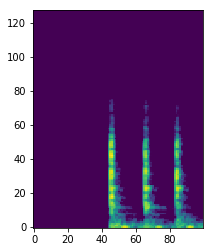

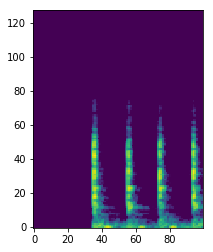

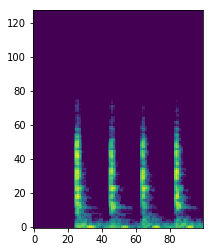

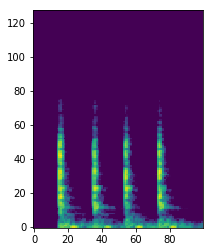

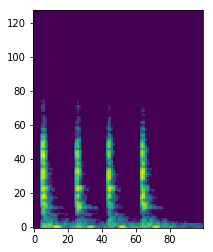

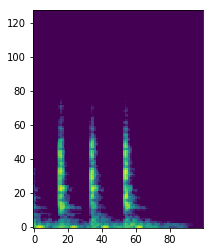

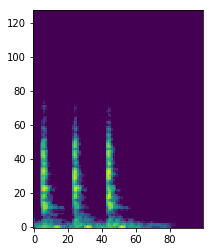

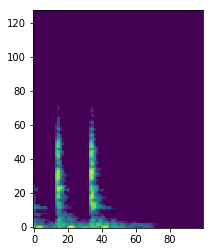

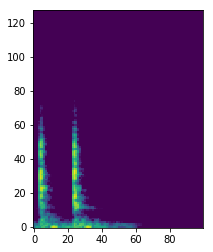

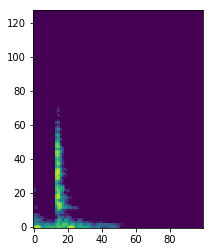

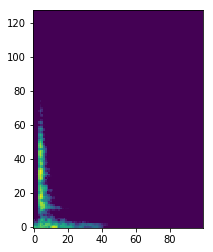

In [211]:
#test splitting spectogram
a,b = splitSpectrogram(10)
assert len(a) == len(b)

In [206]:
#allows user to play different samples without rerunning cell
@interact(idx=(0,len(fileInfo_DF)))
def playAudio(idx):
    print('Category: %s'% fileInfo_DF['category'][idx])
    
    sample_rate, wave = wavfile.read(os.path.join(audioFiles, fileInfo_DF['filename'][idx])) #read in file

    #normalize wave
    #normalize 16 bit signal by diving by max
    normWave = wave.copy().astype(float)
    normWave = normWave + 0.5 / ((2**16 -1) / 2) 
    #scale amplitudes from -1 to 1 wave by dividing by max
    normWave = normWave / np.max(np.abs(normWave))
    
    plt.plot(normWave)
    plt.show()
    
    #convert spectrogram amplitudes to decibels using log
    spectrogram = librosa.feature.melspectrogram(normWave, sr=sample_rate)
    spectrogram = librosa.core.amplitude_to_db(spectrogram)
    
    plt.imshow(spectrogram, origin='lower')
    plt.show()
    
    return Audio(wave, rate=sample_rate)

interactive(children=(IntSlider(value=1000, description='idx', max=2000), Output()), _dom_classes=('widget-int…